# Question C | SVMs hand-on
Yilun Kuang (Mark)

N15511943

FML HW 2



## Question 1

```shell
# Login to the computing cluster
ssh yk2516@greene.hpc.nyu.edu
cd /scratch/yk2516/svm

# Download libsvm github repo
git clone https://github.com/cjlin1/libsvm.git
cd libsvm
make

# Install the libsvm pypi packages on the system
singularity exec --nv --overlay /scratch/yk2516/singularity/overlay-25GB-500K-0.ext3:rw /scratch/work/public/singularity/cuda11.3.0-cudnn8-devel-ubuntu20.04.sif /bin/bash -c "
pip install -U libsvm-official

"

```

## Question 2

```shell
# Download the abalone dataset that is already scaled
wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone_scale

# Alternatively, get the raw data from the link below and do the preprocessing
wget http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
```

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
def preprocess(train_length = 3133):
    pd_tmp = pd.read_csv('abalone.data',header=None)
    sex_map = {'M':("1 0 0"),'F':("0 1 0"),'I':("0 0 1")}
    pd_tmp[0]=pd_tmp[0].apply(lambda x: sex_map[x])
    pd_sex = pd_tmp[0].str.split(expand=True)
    pd_tmp = pd_tmp.drop(columns=[0])
    pd_tmp = pd.concat([pd_sex, pd_tmp], axis=1)
    label_col = np.array(pd_tmp[8])
    new_label = np.ones(len(pd_tmp[8]),dtype=np.float64)
    ind_smaller_than_10 = np.where(label_col<=9)[0]
    new_label[ind_smaller_than_10]= np.float64(-1) # new_label is y_test now
    pd_tmp[8] = new_label
    pd_tmp.columns = range(pd_tmp.shape[1])
    cols = list(pd_tmp.columns)
    cols = [cols[-1]] + cols[:-1]
    pd_tmp = pd_tmp[cols]
    pd_tmp.columns = range(pd_tmp.shape[1])
    cols = list(pd_tmp.columns)
    for cols_name in cols:
        if cols_name != 0:
            pd_tmp[cols_name] = pd_tmp[cols_name].apply(lambda x: str(cols_name)+":"+str(x))
    pd_tmp[0] = pd_tmp[0].apply(lambda x: int(x))
    pd_tmp.to_csv('abalone_pre_scale.data',index=False,header=False,sep=" ")
    train_set = pd_tmp[0:train_length]
    test_set = pd_tmp[train_length:]
    train_set.to_csv('abalone_pre_scale_train.data',index=False,header=False,sep=" ")
    test_set.to_csv('abalone_pre_scale_test.data',index=False,header=False,sep=" ")

In [3]:
preprocess()

In [4]:
os.system("./svm-scale -s scaling_paras/scale_par.txt abalone_pre_scale_train.data > abalone_scaled_train.data")
os.system("./svm-scale -r scaling_paras/scale_par.txt abalone_pre_scale_test.data > abalone_scaled_test.data")

0

## Question 3

In [5]:
import scipy
from libsvm.svmutil import *

In [7]:
y, x = svm_read_problem('abalone_scale', return_scipy = True)

# Train & Test split
train_length = 3133
y_train, x_train = y[0:train_length], x[0:train_length, :]
y_test, x_test = y[train_length:], x[train_length:, :]

# Transform the train dataset into binary classification problem
new_label = np.ones(train_length,dtype=np.float64)
ind_smaller_than_10 = np.where(y_train<=9)[0]
new_label[ind_smaller_than_10]= np.float64(0) # new_label is y_test now

train_dataset = np.array(list(map(lambda x,y: (x,y), x_train,new_label)))

In [4]:
# Transform the test dataset into binary classification problem
new_label_test = np.ones(len(y)-train_length,dtype=np.float64)
ind_smaller_than_10_test = np.where(y_test<=9)[0]
new_label_test[ind_smaller_than_10_test]= np.float64(0) # new_label is y_test now

y_test = new_label_test

In [5]:
# Generate k-fold split
k = 5
lst_k_fold_dataset = []
np.random.shuffle(train_dataset)
ind_increment = int(np.floor(len(train_dataset)/k))

start_ind = 0
end_ind = ind_increment
for i in range(k):
    lst_k_fold_dataset.append(train_dataset[start_ind:end_ind])
    start_ind += ind_increment
    end_ind += ind_increment

In [6]:
ploy_degree_lst = [1, 2, 3, 4, 5]
k_val_sup = 9
kernel_type = "1"

In [149]:
lst_acc_ploy_degree = []

for ploy_degree in ploy_degree_lst:
    lst_acc_k_val = []
    for k_val in range(-k_val_sup, k_val_sup): # C = -3k to 3k
        lst_cross_validation_acc = []
        for ind, train_set in enumerate(lst_k_fold_dataset):
            X_test_tmp = train_set[:,0]
            y_test_tmp = train_set[:,1]
            
            X_tmp = np.concatenate([lst_k_fold_dataset[i] for i,x in enumerate(lst_k_fold_dataset) if i!=ind])[:,0]
            y_tmp = np.concatenate([lst_k_fold_dataset[i] for i,x in enumerate(lst_k_fold_dataset) if i!=ind])[:,1]
    
            m = svm_train(y_tmp, scipy.sparse.vstack(X_tmp),"-c %s -t %s -d %s -q" % (3**k_val, kernel_type, ploy_degree))
            p_label, p_acc, p_val = svm_predict(y_test_tmp, scipy.sparse.vstack(X_test_tmp), m)
            
            lst_cross_validation_acc.append(p_acc[1])
            
        p_acc_cross_validated = np.mean(lst_cross_validation_acc)
        lst_acc_k_val.append(lst_cross_validation_acc)
        print(f"Poly_Degree: {ploy_degree} | k: {k_val} | p_error_cross_validated is {p_acc_cross_validated}")
    
    lst_acc_ploy_degree.append(lst_acc_k_val)   

Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (classification)
Accuracy = 49.6805% (311/626) (classification)
Accuracy = 53.6741% (336/626) (classification)
Poly_Degree: 1 | k: -9 | p_error_cross_validated is 0.49009584664536743
Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (classification)
Accuracy = 49.6805% (311/626) (classification)
Accuracy = 53.6741% (336/626) (classification)
Poly_Degree: 1 | k: -8 | p_error_cross_validated is 0.49009584664536743
Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (classification)
Accuracy = 49.6805% (311/626) (classification)
Accuracy = 53.6741% (336/626) (classification)
Poly_Degree: 1 | k: -7 | p_error_cross_validated is 0.49009584664536743
Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (c

Accuracy = 74.2812% (465/626) (classification)
Accuracy = 75.7188% (474/626) (classification)
Accuracy = 72.0447% (451/626) (classification)
Accuracy = 76.0383% (476/626) (classification)
Poly_Degree: 2 | k: 0 | p_error_cross_validated is 0.2555910543130991
Accuracy = 75.7188% (474/626) (classification)
Accuracy = 76.0383% (476/626) (classification)
Accuracy = 78.9137% (494/626) (classification)
Accuracy = 74.2812% (465/626) (classification)
Accuracy = 78.754% (493/626) (classification)
Poly_Degree: 2 | k: 1 | p_error_cross_validated is 0.23258785942492013
Accuracy = 78.4345% (491/626) (classification)
Accuracy = 77.7955% (487/626) (classification)
Accuracy = 80.5112% (504/626) (classification)
Accuracy = 75.7188% (474/626) (classification)
Accuracy = 81.3099% (509/626) (classification)
Poly_Degree: 2 | k: 2 | p_error_cross_validated is 0.21246006389776356
Accuracy = 79.7125% (499/626) (classification)
Accuracy = 78.5942% (492/626) (classification)
Accuracy = 81.1502% (508/626) (classi

Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (classification)
Accuracy = 49.6805% (311/626) (classification)
Accuracy = 53.6741% (336/626) (classification)
Poly_Degree: 4 | k: -9 | p_error_cross_validated is 0.49009584664536743
Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (classification)
Accuracy = 49.6805% (311/626) (classification)
Accuracy = 53.6741% (336/626) (classification)
Poly_Degree: 4 | k: -8 | p_error_cross_validated is 0.49009584664536743
Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (classification)
Accuracy = 49.6805% (311/626) (classification)
Accuracy = 53.6741% (336/626) (classification)
Poly_Degree: 4 | k: -7 | p_error_cross_validated is 0.49009584664536743
Accuracy = 50.1597% (314/626) (classification)
Accuracy = 49.8403% (312/626) (classification)
Accuracy = 51.5974% (323/626) (c

Accuracy = 73.3227% (459/626) (classification)
Accuracy = 73.9617% (463/626) (classification)
Accuracy = 73.1629% (458/626) (classification)
Accuracy = 71.885% (450/626) (classification)
Accuracy = 73.1629% (458/626) (classification)
Poly_Degree: 5 | k: 0 | p_error_cross_validated is 0.2690095846645367
Accuracy = 73.3227% (459/626) (classification)
Accuracy = 74.1214% (464/626) (classification)
Accuracy = 74.1214% (464/626) (classification)
Accuracy = 72.3642% (453/626) (classification)
Accuracy = 74.2812% (465/626) (classification)
Poly_Degree: 5 | k: 1 | p_error_cross_validated is 0.26357827476038337
Accuracy = 73.8019% (462/626) (classification)
Accuracy = 74.1214% (464/626) (classification)
Accuracy = 74.4409% (466/626) (classification)
Accuracy = 72.8435% (456/626) (classification)
Accuracy = 74.7604% (468/626) (classification)
Poly_Degree: 5 | k: 2 | p_error_cross_validated is 0.26006389776357824
Accuracy = 73.9617% (463/626) (classification)
Accuracy = 74.4409% (466/626) (classi

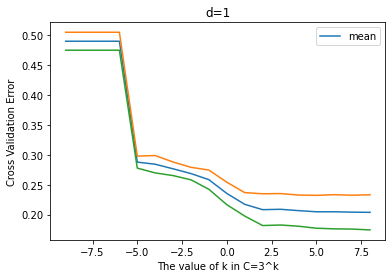

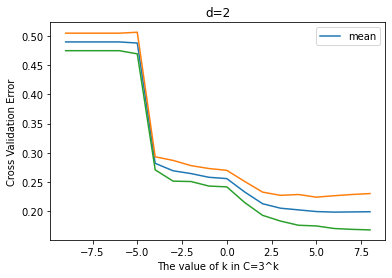

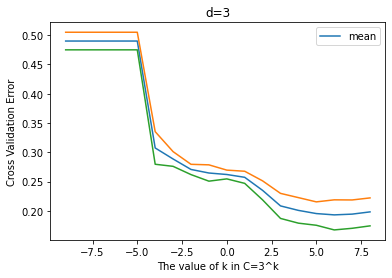

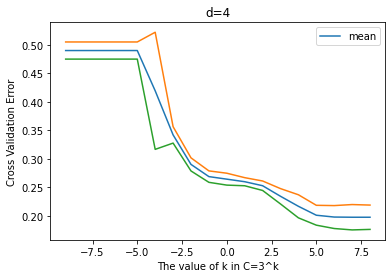

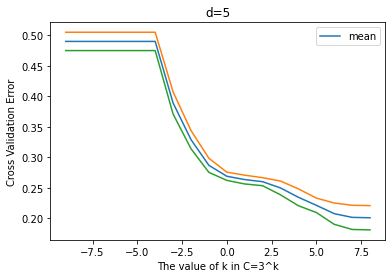

In [171]:
import matplotlib.pyplot as plt
import math

lst_cross_validated_error = []
for i in range(len(lst_acc_ploy_degree)):
    plt.figure()
    mean_val_lst = list(map(lambda x: np.mean(x), lst_acc_ploy_degree[i]))
    std_val_lst = list(map(lambda x: np.std(x), lst_acc_ploy_degree[i]))
    lst_cross_validated_error.append(mean_val_lst)

    plt.plot([math.log(3**k_val,3) for k_val in range(-k_val_sup, k_val_sup)],mean_val_lst, label="mean")
    plt.plot([math.log(3**k_val,3) for k_val in range(-k_val_sup, k_val_sup)],np.add(mean_val_lst,std_val_lst))#, label="mean")
    plt.plot([math.log(3**k_val,3) for k_val in range(-k_val_sup, k_val_sup)],np.subtract(mean_val_lst,std_val_lst))#, label="mean")

    plt.title(f"d={ploy_degree_lst[i]}")
    plt.xlabel("The value of k in C=3^k")
    plt.ylabel("Cross Validation Error")
    plt.legend()
    

## Question 4

In [218]:
argmin_ind = np.unravel_index(np.argmin(np.array(lst_cross_validated_error)), np.array(lst_cross_validated_error).shape)
k_lst = [i for i in range(-k_val_sup,k_val_sup)]
best_d = ploy_degree_lst[argmin_ind[0]]
best_k = k_lst[argmin_ind[1]]
best_C = 3**(k_lst[argmin_ind[1]])
print(f"The minimum cross validation error is {np.min(np.array(lst_cross_validated_error))}")
print(f"The index of the minimum cross validation error is {argmin_ind}")
print(f"The best C: {best_C} | The best d: {best_d}")

The minimum cross validation error is 0.19297124600638976
The index of the minimum cross validation error is (2, 15)
The best C: 729 | The best d: 3


In [298]:
# Calculate test error
sv_lst = []
lst_test_error = []
for i in range(len(ploy_degree_lst)):
    best_m = svm_train(new_label, x_train,"-c %s -t %s -d %s -q" % (best_C, kernel_type, ploy_degree_lst[i]))
    p_label, p_acc, p_val = svm_predict(y_test, x_test, best_m)
    lst_test_error.append(p_acc[1])
    sv_lst.append(best_m.get_nr_sv())


Accuracy = 77.1073% (805/1044) (classification)
Accuracy = 78.9272% (824/1044) (classification)
Accuracy = 78.4483% (819/1044) (classification)
Accuracy = 78.6398% (821/1044) (classification)
Accuracy = 79.5977% (831/1044) (classification)


Text(0.5, 1.0, 'Test Error for the best C=C^*')

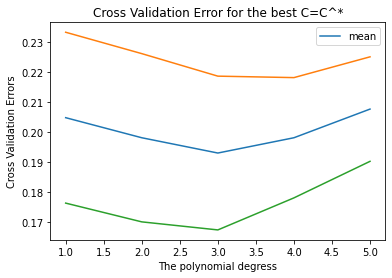

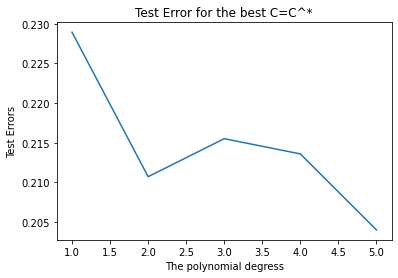

In [274]:
lst_cross_err_for_best_C = []

for i in range(len(ploy_degree_lst)):
    ind_C = np.where(np.array(k_lst)==best_k)[0][0]
    cross_err = lst_acc_ploy_degree[i][ind_C]
    
    mean_cross_err = np.mean(cross_err)
    std_cross_err = np.std(cross_err)
    
    lst_cross_err_for_best_C.append([mean_cross_err,std_cross_err])
    
# Cross Validation Error
plt.figure()
plt.plot(ploy_degree_lst,np.array(lst_cross_err_for_best_C)[:,0],label = "mean")
plt.plot(ploy_degree_lst,np.add(np.array(lst_cross_err_for_best_C)[:,0], np.array(lst_cross_err_for_best_C)[:,1]))
plt.plot(ploy_degree_lst,np.subtract(np.array(lst_cross_err_for_best_C)[:,0], np.array(lst_cross_err_for_best_C)[:,1]))
plt.legend()
plt.xlabel("The polynomial degress")
plt.ylabel("Cross Validation Errors")
plt.title("Cross Validation Error for the best C=C^*")

# Test Error
plt.figure()
plt.plot(ploy_degree_lst, lst_test_error)
plt.xlabel("The polynomial degress")
plt.ylabel("Test Errors")
plt.title("Test Error for the best C=C^*")

Text(0.5, 1.0, 'Numbers of support vectors for the best C=C^*')

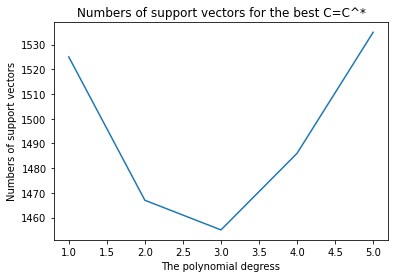

In [299]:
# Numbers of support vectors
plt.figure()
plt.plot(ploy_degree_lst, sv_lst)
plt.xlabel("The polynomial degress")
plt.ylabel("Numbers of support vectors")
plt.title("Numbers of support vectors for the best C=C^*")

## Question 5

In [311]:
lst_train_err = []
lst_test_err = []

for num_exs in range(1,train_length,500):
    best_m = svm_train(new_label[:num_exs], x_train[:num_exs],"-c %s -t %s -d %s -q" % (best_C, kernel_type, best_d))
    
    p_label, p_acc_train, p_val = svm_predict(new_label[:num_exs], x_train[:num_exs], best_m)
    p_label, p_acc_test, p_val = svm_predict(y_test, x_test, best_m)
    
    lst_train_err.append(p_acc_train[1])
    lst_test_err.append(p_acc_test[1])

Accuracy = 100% (1/1) (classification)
Accuracy = 52.2989% (546/1044) (classification)
Accuracy = 87.2255% (437/501) (classification)
Accuracy = 72.4138% (756/1044) (classification)
Accuracy = 83.6164% (837/1001) (classification)
Accuracy = 74.8084% (781/1044) (classification)
Accuracy = 82.545% (1239/1501) (classification)
Accuracy = 79.6935% (832/1044) (classification)
Accuracy = 81.3093% (1627/2001) (classification)
Accuracy = 78.9272% (824/1044) (classification)
Accuracy = 81.6074% (2041/2501) (classification)
Accuracy = 79.4061% (829/1044) (classification)
Accuracy = 81.7727% (2454/3001) (classification)
Accuracy = 78.2567% (817/1044) (classification)


Text(0.5, 1.0, 'The training and test errors at best C and best d')

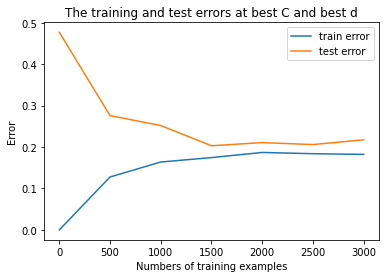

In [314]:
plt.figure()
plt.plot([num_exs for num_exs in range(1,train_length,500)], lst_train_err, label="train error")
plt.plot([num_exs for num_exs in range(1,train_length,500)], lst_test_err, label="test error")
plt.legend()
plt.xlabel("Numbers of training examples")
plt.ylabel("Error")
plt.title("The training and test errors at best C and best d")

## Question 6 c)

For the hinge loss minimization problem of SVM, we consider the sklearn library implementation.

By sklearn documentation, the `SGDClassifier` trained with the hinge loss using Stochastic Gradient Descent is equivalent to a linear SVM.

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

In [12]:
clf = SGDClassifier(loss="hinge")

In [64]:
# Test Error
clf.fit(x_train, new_label)
pred_svm_test = clf.predict(x_test)
svm_hinge_acc_Test = accuracy_score(y_test,pred_svm_test)

In [52]:
# Five-Folds cross validation error
lst_svm_hinge_cross_validation_acc = []

for ind, train_set in enumerate(lst_k_fold_dataset):
    X_test_tmp = train_set[:,0]
    y_test_tmp = train_set[:,1]

    X_tmp = np.concatenate([lst_k_fold_dataset[i] for i,x in enumerate(lst_k_fold_dataset) if i!=ind])[:,0]
    y_tmp = np.concatenate([lst_k_fold_dataset[i] for i,x in enumerate(lst_k_fold_dataset) if i!=ind])[:,1]
    
    clf.fit(scipy.sparse.vstack(X_tmp),np.array(y_tmp,dtype='float'))
    pred_svm_hinge = clf.predict(scipy.sparse.vstack(X_test_tmp))
    svm_hinge_acc = accuracy_score(np.array(y_test_tmp,dtype='float'),pred_svm_hinge)
    
    lst_svm_hinge_cross_validation_acc.append(svm_hinge_acc)

Text(0.5, 1.0, 'Five Fold Cross Validation Error for SVM with Hinge Loss trained using SGD')

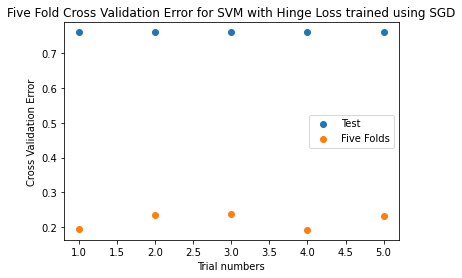

In [67]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter([1,2,3,4,5],[svm_hinge_acc_Test]*5,label="Test")
plt.scatter([1,2,3,4,5],[1-i for i in lst_svm_hinge_cross_validation_acc], label="Five Folds")
plt.xlabel("Trial numbers")
plt.ylabel("Cross Validation Error")
plt.legend()
plt.title("Five Fold Cross Validation Error for SVM with Hinge Loss trained using SGD")